<a href="https://akademie.datamics.com/kursliste/"><a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
airline = pd.read_csv('airline_passengers.csv',index_col="Month")

In [17]:
airline.dropna(inplace=True)
airline.index = pd.to_datetime(airline.index)

In [18]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


# SMA
## Einfacher Gleitender Mittelwert (Simple Moving Average)

Wir haben schon gesehen, wie man einen einfachen gleitenden Mittelwert erstellt, hier eine kurze Wiederholung:

In [19]:
airline['6-month-SMA']=airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA']=airline['Thousands of Passengers'].rolling(window=12).mean()

In [24]:
airline.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,NaN,NaN
1949-03-01,132.0,NaN,NaN
1949-04-01,129.0,NaN,NaN
1949-05-01,121.0,NaN,NaN
1949-06-01,135.0,124.500000,NaN
1949-07-01,148.0,130.500000,NaN
1949-08-01,148.0,135.500000,NaN
1949-09-01,136.0,136.166667,NaN


<AxesSubplot: xlabel='Month'>

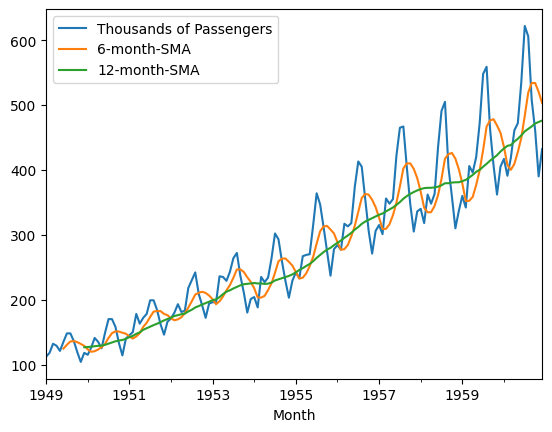

In [25]:
airline.plot()

# EWMA
## Exponentiell Gewichteter Gleitender Mittelwert (Exponentially-weighted moving average) 

Wir haben gerade gesehen, wie man den SMA basierend auf einem bestimmten Fenster berechnet. Allerdings hat der einfache SMA einige "Schwächen".
* Kleinere Fenster erzeugen eher mehr Rauschen als Signal.
* Er läuft immer um die Größe des Fensters hinterher (lag).
* Er erreicht nie das volle Hoch oder Tief der Daten, da er mittelt.
* Er sagt Dir nicht wirklich was über mögliches Verhalten in der Zukunft; er sagt Dir einfach nur etwas über den Trend in Deinen Daten
* Extreme historische Werte können Deinen SMA erheblich verzerren.

Um ein paar von diesen Problemen zu beheben können wir einen EWMA (exponentiell gewichteten gleitenden Mittelwert) verwenden.

Der EWMA erlaubt uns, den "Lag" des SMA zu reduzieren und gewichtet diejenigen Werte stärker, die vor kürzerer Zeit aufgetreten sind (daher der Name). Das Ausmaß des Gewichts, das den neuesten Werten zugefügt wird, hängt von den genauen Parametern ab, die im EWMA verwendet werden und von der Anzahl der Perioden pro Fenster. 

[Mehr Details zur Mathematik dahinter hier](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)
Hier die kürzere Version der Erklärung, was hinter dem EWMA steckt:

Die Formel für EWMA ist:

$ y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i} $

Wobei x_t der Eingabewert, w_i das angefügte Gewicht (Beachte, wie es von i=0 bis t variieren kann) und y_t die Ausgabe ist.

Die Frage ist jetzt, wie definieren wir den Gewichtsterm w_i?

Das kommt auf den Korrekturparameter an, den Du der Methode .ewm() lieferst.

Wenn dieser True ist (Default), werden gewichtete Durchschnitte mit den Gewichten berechnet:

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

Wenn er False ist, werden die gleitenden Mittelwerte wie folgt berechnet:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

was äquivalent dazu ist, folgende Gewichte zu nehmen:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

Wenn adjust=True, haben wir y0=x0 und aus der obigen Darstellung wissen wir yt=αxt+(1−α)yt−1, daher können wir vermuten, dass x0 kein gewöhnlicher Wert ist, sondern ein exponentiell gewichteter Moment der unendlichen Reihe bis zu diesem Punkt.

Es muss gelten 0<α≤1, und obwohl es seit Version 0.18.0 möglich ist, α direkt zu übergeben, ist es oft einfacher, die Spanne, das Massenzentrum (center of mass (com)) oder die Halbwertszeit eines EW Moments zu betrachten:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{für die Spanne}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{für das Massenzentrum}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{für die Halbwertszeit}\ h > 0
 \end{cases}\end{split}

* Die Spanne korreliert mit dem sogenannten "N-Tages EW beweglichen Durchschnitt" (“N-day EW moving average”).
* Das Massenzentrum hat eine eher physikalische Interpretation. Als Spanne ausgedrückt wäre es: c=(s−1)/2
* Die Halbwertszeit ist die Zeit, die es dauert, bis das exponentielle Gewicht auf die Hälfte seines Wertes gefallen ist.
* Alpha spezifiziert den Glättungsfaktor (smoothing factor) direkt.

In [38]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(alpha = 0.7).mean()
airline['EWMA12_2'] = airline['Thousands of Passengers'].ewm(alpha = 0.1).mean()
airline['EWMA12_3'] = airline['Thousands of Passengers'].ewm(span=12).mean()

<AxesSubplot: xlabel='Month'>

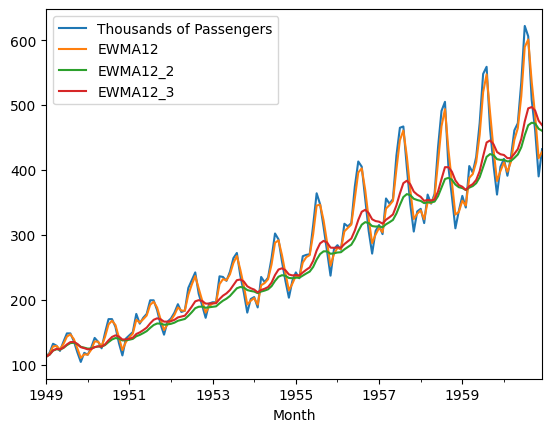

In [39]:
airline[['Thousands of Passengers','EWMA12', 'EWMA12_2', 'EWMA12_3']].plot()

# Super! Das war's fürs Erste, schauen wir uns jetzt das ARIMA Modell an!